In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import seaborn as sns
import pickle
from scipy.stats import norm
from scipy.stats import normaltest

In [2]:
with open('skeleton_distance_cache.pkl', 'rb') as f:
    distances = pickle.load(f)
with open('fm_nodes.pkl', 'rb') as f:
    fm_nodes = pickle.load(f)

In [3]:
def test_fit(skel_id, node_id):
    data = distances[skel_id][node_id]
    #d, p = kstest(data, 'norm')
    chi, p = normaltest(data)
    return chi, p

In [4]:
def plot_histogram_and_gaussian(skel_id, node_id, data, show=True, save_folder=None):
    labels = ['not-smoothed', 'sliding-window', 'breadth-first']
    # data = distances[skel_id][node_id]
    n_plots = len(data)
    # fig, ax = plt.subplots(1, n_plots, figsize=(12, 12))
    fig, ax = plt.subplots(n_plots, figsize=(12, 12))
    for ii, dd in enumerate(data):
        d = dd[skel_id][node_id]
        n_pix = len(d)
        mu, sigma = norm.fit(d)
        dmax = np.max(d)
        if dmax < 2000:
            drange = (0, 2000)
        else:
            drange = None
        n, bins, patches = ax[ii].hist(d, bins=64, density=True, range=drange)
        y = norm.pdf(bins, mu, sigma)
        ax[ii].plot(bins, y, linewidth=2)
        if ii == n_plots - 1:
            ax[ii].set_xlabel('Distance [nm]')
        ax[ii].set_title('%s: mean = %.2f, sigma = %.2f, n_pix=%i' % (labels[ii], mu, sigma, n_pix))
    if show:
        plt.show()
    else:
        assert save_folder is not None
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        have_fm = False
        if skel_id in fm_nodes:
            if node_id in fm_nodes[skel_id]:
                have_fm = True
        if have_fm:
            fold = os.path.join(save_folder, 'explicit_merge')
            if not os.path.exists(fold):
                os.mkdir(fold)
            plt.savefig(os.path.join(fold, 'skel%i_node%i.png' % (skel_id, node_id)))
        else:
            fold = os.path.join(save_folder, 'no_explicit_merge')
            if not os.path.exists(fold):
                os.mkdir(fold)
            plt.savefig(os.path.join(fold, 'skel%i_node%i.png' % (skel_id, node_id)))
    plt.close()

In [5]:
def find_outliers(skel_id, node_id):
    data = distances[skel_id][node_id]
    mu, sigma = norm.fit(data)
    threshold = mu + 3 * sigma
    outliers = np.sum(data > threshold)
    return outliers

In [5]:
print(len(distances))
print(type(distances))
print(distances.keys())
skel_id = list(distances.keys())[2]
skel_distances = distances[skel_id]
print(type(skel_distances))
node_ids = list(skel_distances.keys())
print('number of points')
n_points = sum(len(dist) for dist in distances.values())
print(n_points)

6
<class 'dict'>
dict_keys([2737958, 515319, 203840, 205033, 23005, 37250])
<class 'dict'>
number of points
6064


In [3]:
def smooth_distance_stats(window=2):
    import z5py
    from cremi_tools.skeletons import smooth_sliding_window
    skeleton_folder = '/home/papec/Downloads/skeletons'
    skeleton_ids = os.listdir(skeleton_folder)
    smoothed_distances = {}
    for skel_id in skeleton_ids:
        skel_path = os.path.join(skeleton_folder, skel_id)
        edges = z5py.File(skel_path)['edges'][:]
        skel_id = int(skel_id)
        smoothed_distances[skel_id] = smooth_sliding_window(distances[skel_id], edges, window)
    return smoothed_distances

# smoothed_distances = smooth_distance_stats()

In [2]:
def smooth_distance_stats_bfs(window=2):
    import z5py
    from cremi_tools.skeletons import smooth_bfs
    skeleton_folder = '/home/papec/Downloads/skeletons'
    skeleton_ids = os.listdir(skeleton_folder)
    smoothed_distances = {}
    for skel_id in skeleton_ids:
        skel_path = os.path.join(skeleton_folder, skel_id)
        edges = z5py.File(skel_path)['edges'][:]
        skel_id = int(skel_id)
        smoothed_distances[skel_id] = smooth_bfs(distances[skel_id], edges, window)
    return smoothed_distances

# smoothed_distances_bfs = smooth_distance_stats_bfs()

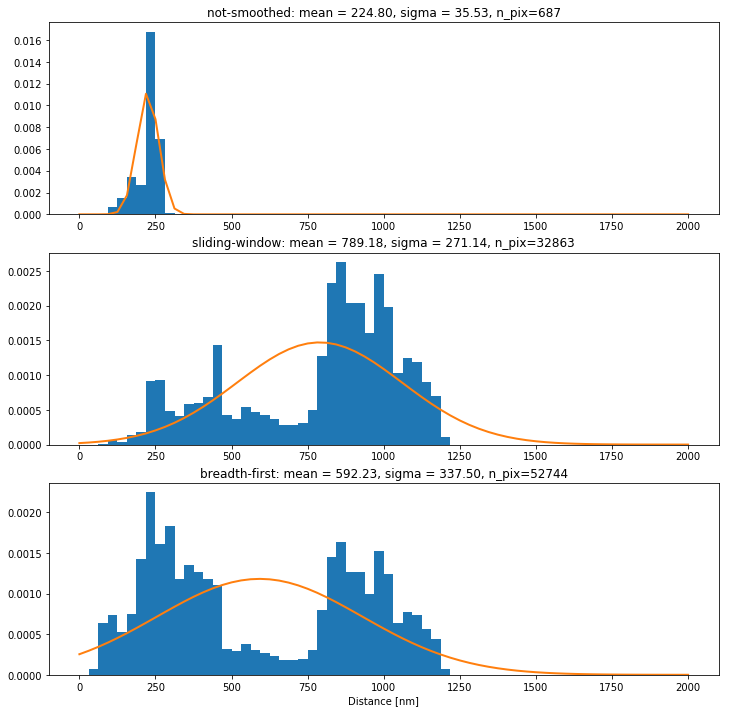

In [42]:
for node_id in node_ids[10:11]:
    plot_histogram_and_gaussian(skel_id, node_id, 
                                [distances, smoothed_distances, smoothed_distances_bfs])
    # n_outliers = find_outliers(skel_id, node_id)
    # print("Number of points further than 3 sigma from mean:")
    # print(n_outliers)
    # print("Fit test:")
    # k, p = test_fit(skel_id, node_id)
    # print(k, p)

In [ ]:
for window in (2, 3, 4, 5, 6, 8, 10, 12, 16, 20):
    save_folder = 'plots_w%i' % window
    sliding_distances = smooth_distance_stats(window)
    bfs_distances = smooth_distance_stats_bfs(window)
    print("Generating plots for window size:", window)
    for skel_id in distances:
        for node_id in distances[skel_id]:
            plot_histogram_and_gaussian(skel_id, node_id,
                                        [distances, sliding_distances, bfs_distances],
                                        False, save_folder)

Generating plots for window size: 2


In [129]:
def compare_merge_and_no_merge():
    mus, mus_merge = [], []
    sigmas, sigmas_merge = [], []
    for skel_id in distances:
        for node_id, data in distances[skel_id].items():
            mu, sigma = norm.fit(data)
            have_fm = False
            if skel_id in fm_nodes:
                if node_id in fm_nodes[skel_id]:
                    have_fm = True
            if have_fm:
                mus_merge.append(mu)
                sigmas_merge.append(sigma)
            else:
                mus.append(mu)
                sigmas.append(sigma)
    print("Stats no merge")
    print(np.mean(mus), np.mean(sigmas))
    plt.hist(mus)
    plt.title('mu')
    plt.show()
    plt.close()
    plt.hist(sigmas)
    plt.show()
    plt.close()
    print("Stats merge")
    print(np.mean(mus_merge), np.mean(sigmas_merge))
    plt.hist(mus_merge)
    plt.title('mu merge')
    plt.show()
    plt.close()
    plt.hist(sigmas_merge)
    plt.title('sigma merge')
    plt.show()
    plt.close()

Stats no merge
408.9000978777516 162.32576139009876


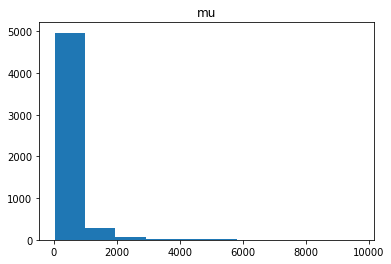

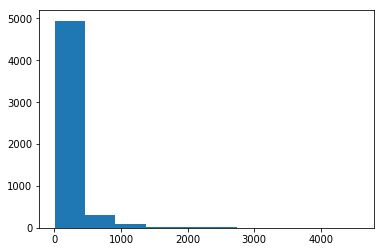

Stats merge
663.3440299364527 277.4047553749067


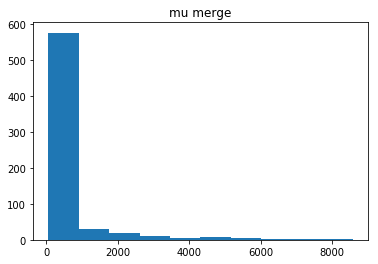

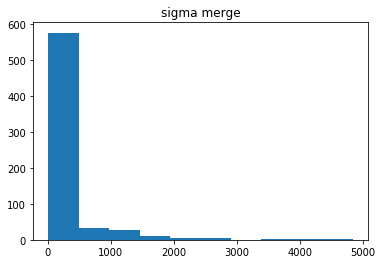

In [130]:
compare_merge_and_no_merge()